In [63]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds
import pylab as plt

In [64]:
def load_mnist(datadir='./data_cache'):
    train_ds = ds.MNIST(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.MNIST(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = np.array(dataset.data) / 255.0  # [0, 1]
        Y = np.array(dataset.targets)
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

X_tr, Y_tr, X_te, Y_te = load_mnist()

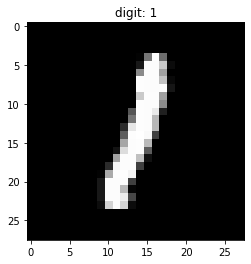

In [65]:
i = np.random.choice(len(X_tr))
plt.imshow(X_tr[i], cmap='gray');
plt.title(f'digit: {Y_tr[i]}');

## Linear Regression

In [66]:
print('original X_tr:', X_tr.shape)

# select 500 random examples
n = 500
I = np.random.choice(len(X_tr), n, replace=False)
X = X_tr[I]
Y = (Y_tr[I] % 2) * 2.0 - 1 # odd/even --> +1/-1
X = X.reshape(-1,  28*28) # flatten

print('reshaped X:', X.shape)
print('reshaped Y:', Y.shape)

original X_tr: (60000, 28, 28)
reshaped X: (500, 784)
reshaped Y: (500,)


Now solve:
$$\text{argmin}_\beta ||X \beta - Y||_2$$
for $\beta \in \mathbb{R}^{784}$

### Stability of Estimates: Normal Equation

In [67]:
print(np.linalg.matrix_rank(X))

500


The rank of the matrix is ultimately constrained by min(n, p) where n is the number of rows and p is the number of columns of the specific matrix. Therefore, here our matrix is not full rank, and furthermore we have more features than data points: p > n: the matrix is going to be singular and it means that there are several solutions to the normal equations. 

In [68]:
Y_test = (Y_te % 2)*2.0 - 1
X_test = X_te.reshape(-1, 28*28)

In [69]:
beta_estimated = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)
estimated_test_set = np.dot(X_test, beta_estimated)
MSE = np.mean((estimated_test_set - Y_test)**2)


In [70]:
MSE

16.851138169283505

### Stability of Estimates: SGD

In [71]:
from autograd.misc.optimizers import sgd

In [33]:
max_iteration = 50 # convex function, we should converge promptly to the global minima
step_size = 1e-3 # small learning rate
weights_init = np.zeros(X.shape[1])

def make_objective(x_train, y_train):
    
    def objective(W, t):
        forward = np.dot(x_train, W)
        mse = np.mean((forward - y_train)**2)
        return mse
    
    def gradient(W,t):
        return 2*np.dot(x_train.T, np.dot(X, W) - y_train)
    return objective, gradient

objective, gradient = make_objective(X, Y)
weights_track = []
def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective_value = objective(weights, iteration)
            if iteration % 1 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective_value, np.linalg.norm(gradient(weights, iteration))))
            weights_track.append(weights)
            # print(weights)

In [ ]:
sgd(gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back, mass=0)

### Mini-batch Stochastic Gradient Descent 

In [72]:
from sklearn.linear_model import SGDRegressor

In [73]:
sgd = SGDRegressor(learning_rate='constant', eta0=1e-3)
sgd.fit(X, Y)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.001, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

Norm of the resulting weight parameter. We expect the norm to be fairly low, since from the lecture we have seen that the solution to OLS when applying OLS is the weight parameter verifying the normal equation, w

In [74]:
print(np.sum(sgd.coef_)**2)

0.8553780062330592


In [77]:
print(np.mean(np.dot(X, sgd.coef_) - Y)**2)

0.132910096236123


This should work only with small intialization weights. Maybe start with weights all = 0.

Overparametrization: SGD should work, like we are doing SGD on subspace. Spectrum shown in class. Make progress as long as 0< I-eta times covariance matrix < 1. 
Met's say that inputs are Gaussian and we plot the eigenvalues. Because overparametrize, we are going to have 0 eigenvalues + some subspace where we behave like a full rank matrix: should be fine.When d is n, we have some small eigenvalues and this kills the optimization. Then what effectively happens is that we don't include the 0, because the vector that we want to learn is ijn the effective subspace of the full rank matrix.Loss in the space we are optimizing in and L2 from the null subspace. In the over-parametrized space, we can ignore some dimensions. COndition number: non-zero eigenvalues. Overparametrized space: we have a null space but we don't make any movement on it.* Anythng less than $10^{-10}$ is 0 here. Effective dimensionality of a network: how much data can it fit up to a certain loss. 

Sgd without momentum

### Spectrum of X

In [37]:
print(X.shape)

(500, 784)


In [50]:
print(np.max(np.linalg.eig(np.dot(X.T, X))[0]))

(18772.859890505562+0j)


In [51]:
print(np.min(np.linalg.eig(np.dot(X.T, X))[0]))

(-2.937279254535514e-14+0j)


In [52]:
print(np.linalg.cond(np.dot(X.T, X)))

inf


However, this is not the *effective* conditioning number of $X^TX$. Let us plot the distribution of eigenvalues of this matrix. 

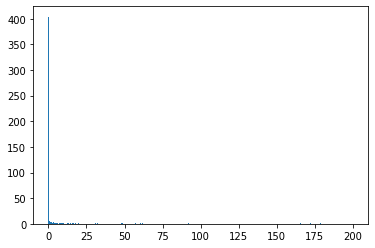

In [27]:
distribution = np.real(np.linalg.eig(np.dot(X.T, X))[0])
plt.hist(distribution, bins = 1000, range =(0, 200))
plt.show()

Then, let us see what happens when we remove all of the 0 eigenvalues, corresponding to a null subspace where we are not effectively making any movements.

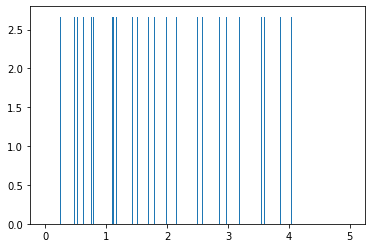

In [29]:
distribution = distribution[distribution > 10e-8]
plt.hist(distribution, bins = 1000, range =(0, 5), density=True)
plt.show()